In [463]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [464]:
image1= cv2.imread('/Users/hesham/Desktop/NU_Master/Computer_vision/lec4/assignment1_partII_students/partII/fishbowl/fishbowl-00.png')
image2=cv2.imread('/Users/hesham/Desktop/NU_Master/Computer_vision/lec4/assignment1_partII_students/partII/fishbowl/fishbowl-01.png')

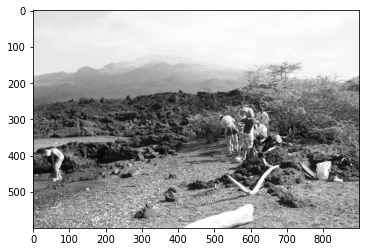

In [465]:
plt.imshow(image1)

# just refreshing

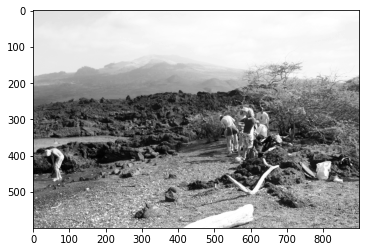

In [466]:
imgGray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
plt.imshow(imgGray,cmap='gray')

# image analysis using ORB feature detcteor

In [467]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(imgGray, None)
des1.shape

(500, 32)

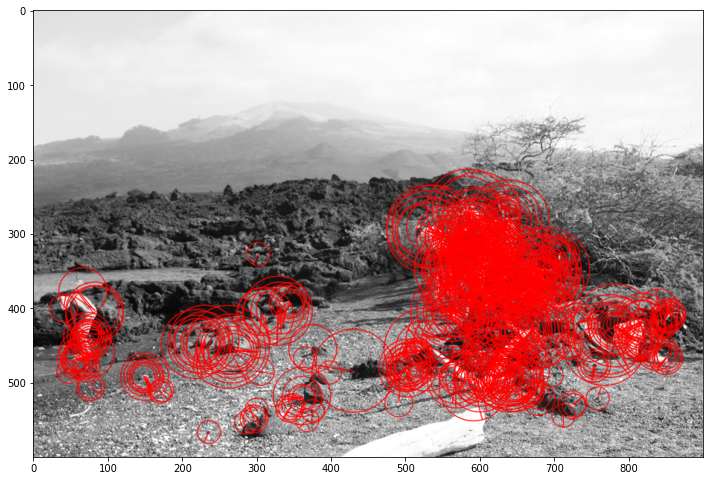

In [468]:
img2 = cv2.drawKeypoints(imgGray, kp1, None, color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(12,12))
plt.imshow(img2[:,:,::-1])

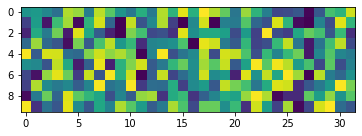

In [469]:
plt.imshow(des1[:10])
# 32 values for each keypoint

# Now Feature matching using FLANN

In [470]:
imgGray2 = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
kp2, des2= orb.detectAndCompute(imgGray2, None)
des1=des

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

In [471]:
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(np.float32(des1),np.float32(des2),k=2)



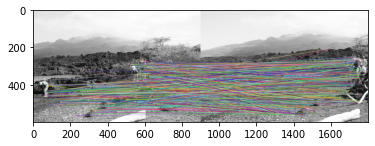

In [472]:
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(imgGray,kp1,imgGray2,kp2,matches,None)

plt.imshow(img3)
plt.show()

# Now RanSac

In [473]:
def Homography(pairs):
    """
    Solves for the homography given any number of pairs of points  based on SVD. 
    """
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x1])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y1])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H



def L2(pair, H):
    
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    
    return np.linalg.norm(np.transpose(p2) - p2_estimate)




def Ransac(points_map, Num_iterations = 1000, threshold = 500):
    BestInliers = set()
    homography = None
    for i in range(Num_iterations):
        pairs=[points_map[i] for i in np.random.choice(len(points_map),4)]

        H = Homography(pairs)

        Inliers= {(c[0],c[1],c[2],c[3]) for c in points_map if L2(c, H) < threshold}

        if len(Inliers) > len(BestInliers):
            BestInliers = Inliers
            homography= H
        
        
    return homography , BestInliers

In [474]:
# Match features using different method. 
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(des1, des2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)





In [475]:
#for match in matches:
    #print(match.queryIdx)

In [476]:
#kp1[match.queryIdx].pt

In [477]:
len(matches)

500

In [478]:
points_map=np.array([
        [kp1[match.queryIdx].pt[0],
        kp1[match.queryIdx].pt[1],
        kp2[match.trainIdx].pt[0],
        kp2[match.trainIdx].pt[1]] for match in matches
    ])

In [479]:
points_map.shape

(500, 4)

In [480]:
#randomly choice 4 points from source image and 4 points from second image to calculate Homography between them
pairs = [points_map[i] for i in np.random.choice(len(points_map), 4)]
len(pairs)

4

In [481]:
pairs
#each row --> 2 points from kp1 and 2 points from kp2

[array([584.64001465, 406.08001709, 828.00006104, 394.56002808]),
 array([602.17358398, 492.68746948, 534.        , 312.        ]),
 array([343.87203979, 392.25604248, 577.15203857, 376.70404053]),
 array([664., 363., 758., 276.])]

In [482]:
H= Homography(pairs)
H.shape

(3, 3)

In [489]:
H2, inliers= Ransac(points_map,Num_iterations = 1000 , threshold = 500)

In [490]:
H2

array([[-6.91082259e-03,  4.07379825e-02,  3.19533944e+02],
       [-5.17739662e-01,  1.23539743e+00,  6.71303849e+01],
       [-1.02476796e-03,  7.09835363e-04,  1.00000000e+00]])

# Visualization

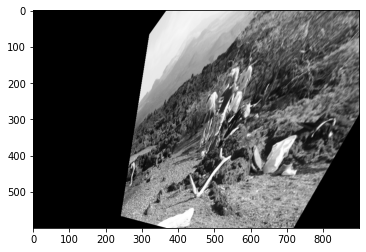

In [491]:
out_final2=cv2.warpPerspective(image1, (H2), (image1.shape[1],image1.shape[0]))

plt.imshow(out_final2)

# Lowest square median  RanSac

In [503]:
def Ransac_Median(points_map, Num_iterations = 1000, threshold = 500):
    BestInliers = set()
    homography = None
    
    intial_median = 20000000000
    
    for i in range(Num_iterations):
        Inliers=set()
        all_errors= []
        pairs=[points_map[i] for i in np.random.choice(len(points_map),4)]
        H = Homography(pairs)
        
        
        for c in points_map:
            error = L2(c, H)
            
            if error < threshold:
                Inliers = np.append(Inliers, (c[0],c[1],c[2],c[3]))
                all_errors = np.append(all_errors, error)
            

        
        
        
        if np.median(all_errors) < intial_median:
            print("lowest median error: ", np.median(all_errors))
            BestInliers = Inliers
            homography= H
            
            intial_median = np.median(all_errors)
        
    return homography , BestInliers

In [507]:
H3, inliers= Ransac_Median(points_map,Num_iterations = 1000 , threshold = 500)

lowest median error:  240.5895009288914
lowest median error:  240.58950092850384
lowest median error:  240.58950092272516
lowest median error:  240.5895009201046
lowest median error:  237.93517403109144
lowest median error:  223.15043750518078
lowest median error:  217.36548718838057


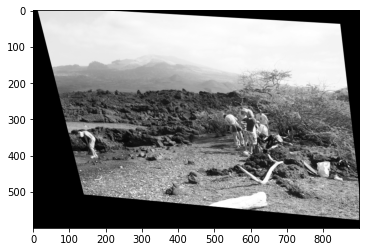

In [508]:
out_final3=cv2.warpPerspective(image1, (H3), (image1.shape[1],image1.shape[0]))

plt.imshow(out_final3)